# 6. Feature engineering using the player stastistics

---
**To be able to execute this notebook, please download your own local version of the data from https://www.kaggle.com/martinellis/nhl-game-data and store it into the folder "data/nhl/nhl_stats/"**



**In addition, please download your own local version of the data from https://www.kaggle.com/camnugent/predict-nhl-player-salaries and store it into the folder "data/nhl/nhl_salaries/"**

---

After first feature modelling and evaluation of the model using logistic regression, some other classifier and some other metrics will be considered.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import math
import time

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMClassifier

from matplotlib import pyplot as plt
from matplotlib import patches

from utils import create_dummy_df
from utils import plot_correlation_matrix
from utils import balance_binary_target

from models import run_logistic_regression
from models import run_lightgbm_classifier
from models import run_kneighbors_classifier

from metrics import save_metrics
from metrics import plot_metrics
from metrics import init_metrics_file

sns.set()

---
## Preparing data used in the previous sections

In [2]:
# read data
df_game_plays = pd.read_csv('data/nhl/nhl_stats/game_plays.csv')
df_game_plays.drop_duplicates(inplace=True)

# drop NaNs, select relevant columns only
df = df_game_plays[['play_id', 'event', 'secondaryType', 'st_x', 'st_y', 'period', 'periodTime']][(df_game_plays.event=='Goal') | (df_game_plays.event=='Shot')]
df.dropna(inplace=True)
df.secondaryType = df.secondaryType.str.replace(" ", "")
df.secondaryType = df.secondaryType.str.replace("-", "")

# Prepare target. Convert categorical event values 'Goal' to a numerical 0/1 value indicating goal
df['goal'] = np.where(df.event=='Goal', 1, 0)
df.drop(columns='event', inplace=True)

# Convert categorical 'secondaryType' column to multiple numerical columns
cat_cols = ['secondaryType']
df = create_dummy_df(df=df, cat_cols=cat_cols, dummy_na=True)
df.drop(columns=['secondaryType_nan'], inplace=True)

#balance targets
df = balance_binary_target(df, target='goal')


In [3]:
# adding feature distance
def dist(df): 
    middle_goal_x = 100 
    middle_goal_y = 0
    return math.hypot(middle_goal_x - df.st_x, middle_goal_y - df.st_y)

df_data_dist = df.copy()
df_data_dist['distance'] = df_data_dist.apply(dist, axis=1)

# cut outliers first
df_data_dist = df_data_dist[df_data_dist.distance<50]

In [4]:
# adding feature angle
def angle(df):     
    middle_goal_x = 100 
    return math.fabs(math.degrees(math.atan2(df.st_x - middle_goal_x, df.st_y)) + 90)

df_data_dist_angle = df_data_dist.copy()
df_data_dist_angle['angle'] = df_data_dist_angle.apply(angle, axis=1)

# cutting outliers
df_data_dist_angle= df_data_dist_angle[df_data_dist_angle.angle<40]

In [5]:
df_data_dist_angle.head()

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance,angle
1758719,2013020685_103,81.0,7.0,1,1089,1,0,0,0,0,0,1,20.248457,20.224859
443030,2015020966_233,55.0,3.0,3,17,1,0,0,0,0,0,1,45.099889,3.814075
2448293,2011020599_61,79.0,-1.0,1,665,1,0,0,0,0,0,1,21.023796,2.726311
68554,2015021010_293,67.0,-3.0,3,659,1,0,0,1,0,0,0,33.136083,5.194429
1366258,2014020377_278,61.0,-1.0,3,199,1,0,0,0,0,0,0,39.012818,1.468801


In [6]:
df_data_dist_angle.shape

(94480, 14)

---
## Adding players to game events

In [7]:
df_player = pd.read_csv('data/nhl/nhl_stats/game_plays_players.csv')
df_player.drop_duplicates(inplace=True)
df_player.head()

,play_id,game_id,player_id,playerType
0,2016020045_4,2016020045,8473604,Winner
1,2016020045_4,2016020045,8473512,Loser
2,2016020045_5,2016020045,8473573,Shooter
3,2016020045_5,2016020045,8473607,Goalie
4,2016020045_6,2016020045,8474141,Scorer


---
Read and filter the data frame twice, once for skate, once for goalie:

In [8]:
df_skater = df_player[df_player.playerType.isin(['Shooter', 'Scorer'])].copy()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)
df_skater.drop(columns=['game_id', 'playerType'], inplace=True)

df_goalie = df_player[df_player.playerType.isin(['Goalie'])].copy()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)
df_goalie.drop(columns=['game_id', 'playerType'], inplace=True)

---
Merge both player types with game plays:

In [9]:
df_data_dist_angle.shape

(94480, 14)

In [10]:
# created new table and merge skaters and golies to the game events
df_data_player = df_data_dist_angle.copy()

df_data_player = df_data_player.merge(df_skater, how='left', on='play_id')
df_data_player = df_data_player.merge(df_goalie, how='left', on='play_id')
df_data_player

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance,angle,skater_id,goalie_id
0,2013020685_103,81.0,7.0,1,1089,1,0,0,0,0,0,1,20.248457,20.224859,8474589,8475831.0
1,2015020966_233,55.0,3.0,3,17,1,0,0,0,0,0,1,45.099889,3.814075,8474613,8474651.0
2,2011020599_61,79.0,-1.0,1,665,1,0,0,0,0,0,1,21.023796,2.726311,8464975,8467950.0
3,2015021010_293,67.0,-3.0,3,659,1,0,0,1,0,0,0,33.136083,5.194429,8476389,8467950.0
4,2014020377_278,61.0,-1.0,3,199,1,0,0,0,0,0,0,39.012818,1.468801,8470120,8474651.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94475,2010020238_55,84.0,-2.0,1,614,0,0,0,0,1,0,0,16.124515,7.125016,8465166,8471715.0
94476,2018020895_138,73.0,-8.0,2,483,0,0,1,0,0,0,0,28.160256,16.504361,8477476,8476883.0
94477,2018020499_74,72.0,21.0,1,822,0,0,0,0,0,0,1,35.000000,36.869898,8480113,8476899.0
94478,2017020873_79,82.0,-4.0,1,962,0,1,0,0,0,0,0,18.439089,12.528808,8473618,8474651.0


In [11]:
df_data_player.isna().sum()

play_id                        0
st_x                           0
st_y                           0
period                         0
periodTime                     0
goal                           0
secondaryType_Deflected        0
secondaryType_SlapShot         0
secondaryType_SnapShot         0
secondaryType_TipIn            0
secondaryType_Wraparound       0
secondaryType_WristShot        0
distance                       0
angle                          0
skater_id                      0
goalie_id                   1072
dtype: int64

In [12]:
# Apparently not all shots were on goal. No golie then. Keeping this rows anyway but replacing goalie by Zero
df_data_player.goalie_id.fillna(0, inplace=True)

========== Logistic Regression ==========
Accuracy: 0.6166
F1 Score: 0.7628
AUC-ROC Score: 0.5245
-----------------------------------------
Precision: 0.6166
Recall: 1.0000


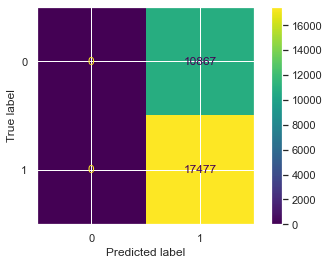

========== LightGBM Classifier ==========
Accuracy: 0.6589
F1 Score: 0.7573
AUC-ROC Score: 0.6679
-----------------------------------------
Precision: 0.6746
Recall: 0.8631


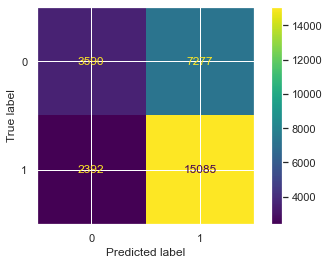

========= KNeighbors Classifier =========
Accuracy: 0.6120
F1 Score: 0.7573
AUC-ROC Score: 0.5238
-----------------------------------------
Precision: 0.6164
Recall: 0.9815


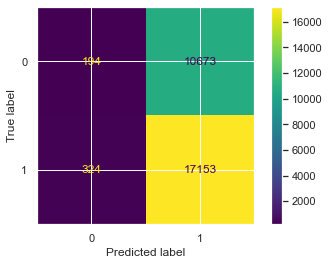

In [13]:
# starting training with player_id
_, lg = run_logistic_regression(df_data_player, conf_matrix=True, roc_curve=False);
_, lgbm = run_lightgbm_classifier(df_data_player, conf_matrix=True, roc_curve=False);
_, knc = run_kneighbors_classifier(df_data_player, conf_matrix=True, roc_curve=False);
save_metrics('6_with_player_ids', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc )

<AxesSubplot:>

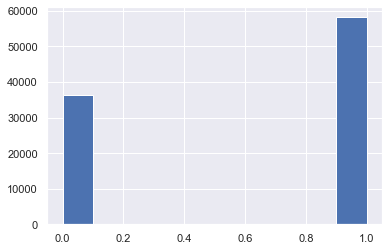

In [14]:
df_data_player.goal.hist()

## Adding player statistics

In [15]:
df_player_info = pd.read_csv('data/nhl/nhl_stats/player_info.csv')
df_player_info.head()

,player_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R


---
Calculating overall savePercentage for each goalie:

In [16]:
df_goalie = pd.read_csv('data/nhl/nhl_stats/game_goalie_stats.csv')
df_goalie = df_goalie.groupby('player_id').agg({'savePercentage':'mean'}).reset_index()
df_goalie.rename(columns={'player_id':'goalie_id'}, inplace=True)
df_goalie.head()                                      

,goalie_id,savePercentage
0,8445275,89.979639
1,8445386,89.914678
2,8445470,86.247964
3,8445769,90.347714
4,8446719,87.575872


---
Calculating overall statistics for each skater:

In [17]:
df_skater = pd.read_csv('data/nhl/nhl_stats/game_skater_stats.csv')
df_skater = df_skater.groupby('player_id').agg({'goals':'sum', 'shots':'sum', 'assists':'sum', 'timeOnIce':'sum'}).reset_index()
df_skater.rename(columns={'player_id':'skater_id'}, inplace=True)
df_skater.head()

,skater_id,goals,shots,assists,timeOnIce
0,8444894,11,66,12,51806
1,8444919,4,174,37,232930
2,8445000,88,696,74,322029
3,8445176,59,532,82,214915
4,8445266,7,185,23,329428


---
Merging it together in the training dataset

In [18]:
df_data_player = df_data_player.merge(df_skater, how='left', on='skater_id')
df_data_player = df_data_player.merge(df_goalie, how='left', on='goalie_id')

df_data_player

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,...,secondaryType_WristShot,distance,angle,skater_id,goalie_id,goals,shots,assists,timeOnIce,savePercentage
0,2013020685_103,81.0,7.0,1,1089,1,0,0,0,0,...,1,20.248457,20.224859,8474589,8475831.0,165,1595,215,680003,91.011471
1,2015020966_233,55.0,3.0,3,17,1,0,0,0,0,...,1,45.099889,3.814075,8474613,8474651.0,213,2362,388,1110527,90.443286
2,2011020599_61,79.0,-1.0,1,665,1,0,0,0,0,...,1,21.023796,2.726311,8464975,8467950.0,315,2164,385,927023,90.382477
3,2015021010_293,67.0,-3.0,3,659,1,0,0,1,0,...,0,33.136083,5.194429,8476389,8467950.0,133,1448,228,626974,90.382477
4,2014020377_278,61.0,-1.0,3,199,1,0,0,0,0,...,0,39.012818,1.468801,8470120,8474651.0,246,1934,281,714929,90.443286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94475,2010020238_55,84.0,-2.0,1,614,0,0,0,0,1,...,0,16.124515,7.125016,8465166,8471715.0,57,948,107,649108,89.653833
94476,2018020895_138,73.0,-8.0,2,483,0,0,1,0,0,...,0,28.160256,16.504361,8477476,8476883.0,82,1012,95,433935,91.413672
94477,2018020499_74,72.0,21.0,1,822,0,0,0,0,0,...,1,35.000000,36.869898,8480113,8476899.0,74,712,104,395001,90.577598
94478,2017020873_79,82.0,-4.0,1,962,0,1,0,0,0,...,0,18.439089,12.528808,8473618,8474651.0,156,1214,229,660467,90.443286


In [19]:
df_data_player.isna().sum()

play_id                        0
st_x                           0
st_y                           0
period                         0
periodTime                     0
goal                           0
secondaryType_Deflected        0
secondaryType_SlapShot         0
secondaryType_SnapShot         0
secondaryType_TipIn            0
secondaryType_Wraparound       0
secondaryType_WristShot        0
distance                       0
angle                          0
skater_id                      0
goalie_id                      0
goals                          0
shots                          0
assists                        0
timeOnIce                      0
savePercentage              1072
dtype: int64

In [20]:
df_data_player.savePercentage.fillna(df_data_player.savePercentage.median(), inplace=True)

In [21]:
# starting training with player stats
_, lg = run_logistic_regression(df_data_player, conf_matrix=False, roc_curve=False);
_, lgbm = run_lightgbm_classifier(df_data_player, conf_matrix=False, roc_curve=False);
_, knc = run_kneighbors_classifier(df_data_player, conf_matrix=False, roc_curve=False);
save_metrics('7_with_player_stats', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc )

========== Logistic Regression ==========
Accuracy: 0.6166
F1 Score: 0.7628
AUC-ROC Score: 0.5365
-----------------------------------------
Precision: 0.6166
Recall: 1.0000
========== LightGBM Classifier ==========
Accuracy: 0.6605
F1 Score: 0.7581
AUC-ROC Score: 0.6740
-----------------------------------------
Precision: 0.6761
Recall: 0.8627
========= KNeighbors Classifier =========
Accuracy: 0.6108
F1 Score: 0.7531
AUC-ROC Score: 0.5322
-----------------------------------------
Precision: 0.6185
Recall: 0.9625


## Adding players salaries

In [22]:
# Data from another dataset
df_players_train = pd.read_csv('data/nhl/nhl_salaries/train.csv')
df_players_test = pd.read_csv('data/nhl/nhl_salaries/test.csv')

df_player_stats = pd.concat([df_players_train, df_players_test])
df_player_stats.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.0,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000.0,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000.0,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000.0,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000.0,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [23]:
df_player_stats = df_player_stats[['First Name', 'Last Name', 'Nat', 'Salary']].rename(columns={'First Name':'firstName', 'Last Name':'lastName', 'Nat':'nationality', 'Salary':'salary'})
df_player_stats.head()

,firstName,lastName,nationality,salary
0,Thomas,Chabot,CAN,925000.0
1,Cody,Ceci,CAN,2250000.0
2,Kyle,Okposo,USA,8000000.0
3,Erik,Gudbranson,CAN,3500000.0
4,Tom,Wilson,CAN,1750000.0


---
Prepare player_info for merging

In [24]:
df_player_info.rename(columns={'player_id':'skater_id'}, inplace=True)
df_player_info.head()

,skater_id,firstName,lastName,nationality,birthCity,primaryPosition,birthDate,birthStateProvince,height,height_cm,weight,shootsCatches
0,8466148,Marian,Hossa,SVK,Stará Lubovna,RW,1979-01-12 00:00:00,NaN,"6' 1""",185.42,207.0,L
1,8465058,Michal,Rozsival,CZE,Vlasim,D,1978-09-03 01:00:00,NaN,"6' 1""",185.42,210.0,R
2,8476906,Shayne,Gostisbehere,USA,Pembroke Pines,D,1993-04-20 01:00:00,FL,"5' 11""",180.34,180.0,L
3,8466285,Brian,Campbell,CAN,Strathroy,D,1979-05-23 01:00:00,ON,"5' 10""",177.80,192.0,L
4,8470607,Brent,Seabrook,CAN,Richmond,D,1985-04-20 01:00:00,BC,"6' 3""",190.50,220.0,R


---
Add additional player's identification data to the target dataset: 

In [25]:
#add name and nationality of the skater
df_data_player = df_data_player.merge(df_player_info[['skater_id', 'firstName', 'lastName', 'nationality']], how='left', on='skater_id')
df_data_player

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,...,skater_id,goalie_id,goals,shots,assists,timeOnIce,savePercentage,firstName,lastName,nationality
0,2013020685_103,81.0,7.0,1,1089,1,0,0,0,0,...,8474589,8475831.0,165,1595,215,680003,91.011471,Tyler,Ennis,CAN
1,2015020966_233,55.0,3.0,3,17,1,0,0,0,0,...,8474613,8474651.0,213,2362,388,1110527,90.443286,Derek,Stepan,USA
2,2011020599_61,79.0,-1.0,1,665,1,0,0,0,0,...,8464975,8467950.0,315,2164,385,927023,90.382477,Daniel,Briere,CAN
3,2015021010_293,67.0,-3.0,3,659,1,0,0,1,0,...,8476389,8467950.0,133,1448,228,626974,90.382477,Vincent,Trocheck,USA
4,2014020377_278,61.0,-1.0,3,199,1,0,0,0,0,...,8470120,8474651.0,246,1934,281,714929,90.443286,Alexander,Semin,RUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94475,2010020238_55,84.0,-2.0,1,614,0,0,0,0,1,...,8465166,8471715.0,57,948,107,649108,89.653833,Craig,Adams,CAN
94476,2018020895_138,73.0,-8.0,2,483,0,0,1,0,0,...,8477476,8476883.0,82,1012,95,433935,91.413672,Artturi,Lehkonen,FIN
94477,2018020499_74,72.0,21.0,1,822,0,0,0,0,0,...,8480113,8476899.0,74,712,104,395001,90.577598,Alex,Iafallo,USA
94478,2017020873_79,82.0,-4.0,1,962,0,1,0,0,0,...,8473618,8474651.0,156,1214,229,660467,90.443286,Mathieu,Perreault,CAN


---
Add salary to the merged dataset:

In [26]:
# add salary based on first name, last name, and the nationality
df_data_player = df_data_player.merge(df_player_stats, how='left', on=['firstName', 'lastName', 'nationality'])
df_data_player

,play_id,st_x,st_y,period,periodTime,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,...,goalie_id,goals,shots,assists,timeOnIce,savePercentage,firstName,lastName,nationality,salary
0,2013020685_103,81.0,7.0,1,1089,1,0,0,0,0,...,8475831.0,165,1595,215,680003,91.011471,Tyler,Ennis,CAN,3650000.0
1,2015020966_233,55.0,3.0,3,17,1,0,0,0,0,...,8474651.0,213,2362,388,1110527,90.443286,Derek,Stepan,USA,NaN
2,2011020599_61,79.0,-1.0,1,665,1,0,0,0,0,...,8467950.0,315,2164,385,927023,90.382477,Daniel,Briere,CAN,NaN
3,2015021010_293,67.0,-3.0,3,659,1,0,0,1,0,...,8467950.0,133,1448,228,626974,90.382477,Vincent,Trocheck,USA,3750000.0
4,2014020377_278,61.0,-1.0,3,199,1,0,0,0,0,...,8474651.0,246,1934,281,714929,90.443286,Alexander,Semin,RUS,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94475,2010020238_55,84.0,-2.0,1,614,0,0,0,0,1,...,8471715.0,57,948,107,649108,89.653833,Craig,Adams,CAN,NaN
94476,2018020895_138,73.0,-8.0,2,483,0,0,1,0,0,...,8476883.0,82,1012,95,433935,91.413672,Artturi,Lehkonen,FIN,NaN
94477,2018020499_74,72.0,21.0,1,822,0,0,0,0,0,...,8476899.0,74,712,104,395001,90.577598,Alex,Iafallo,USA,NaN
94478,2017020873_79,82.0,-4.0,1,962,0,1,0,0,0,...,8474651.0,156,1214,229,660467,90.443286,Mathieu,Perreault,CAN,3000000.0


___
Replace missing salary with median (to ignore outliers):

In [27]:
# replace missing salary
df_data_player.salary.fillna(df_data_player.salary.median(), inplace=True)

In [28]:
df_data_player.isna().sum()

play_id                     0
st_x                        0
st_y                        0
period                      0
periodTime                  0
goal                        0
secondaryType_Deflected     0
secondaryType_SlapShot      0
secondaryType_SnapShot      0
secondaryType_TipIn         0
secondaryType_Wraparound    0
secondaryType_WristShot     0
distance                    0
angle                       0
skater_id                   0
goalie_id                   0
goals                       0
shots                       0
assists                     0
timeOnIce                   0
savePercentage              0
firstName                   0
lastName                    0
nationality                 1
salary                      0
dtype: int64

In [29]:
df_data_player.savePercentage.fillna(df_data_player.savePercentage.median(), inplace=True)

#### Saving data to the dataset DataFrame

In [30]:
df_dataset = df_data_player.copy()

---
As we can see, there are new features for skater making the shot (goals, shots, assists, time on ice, salary) and for the goaling catching it (save percentage)

---

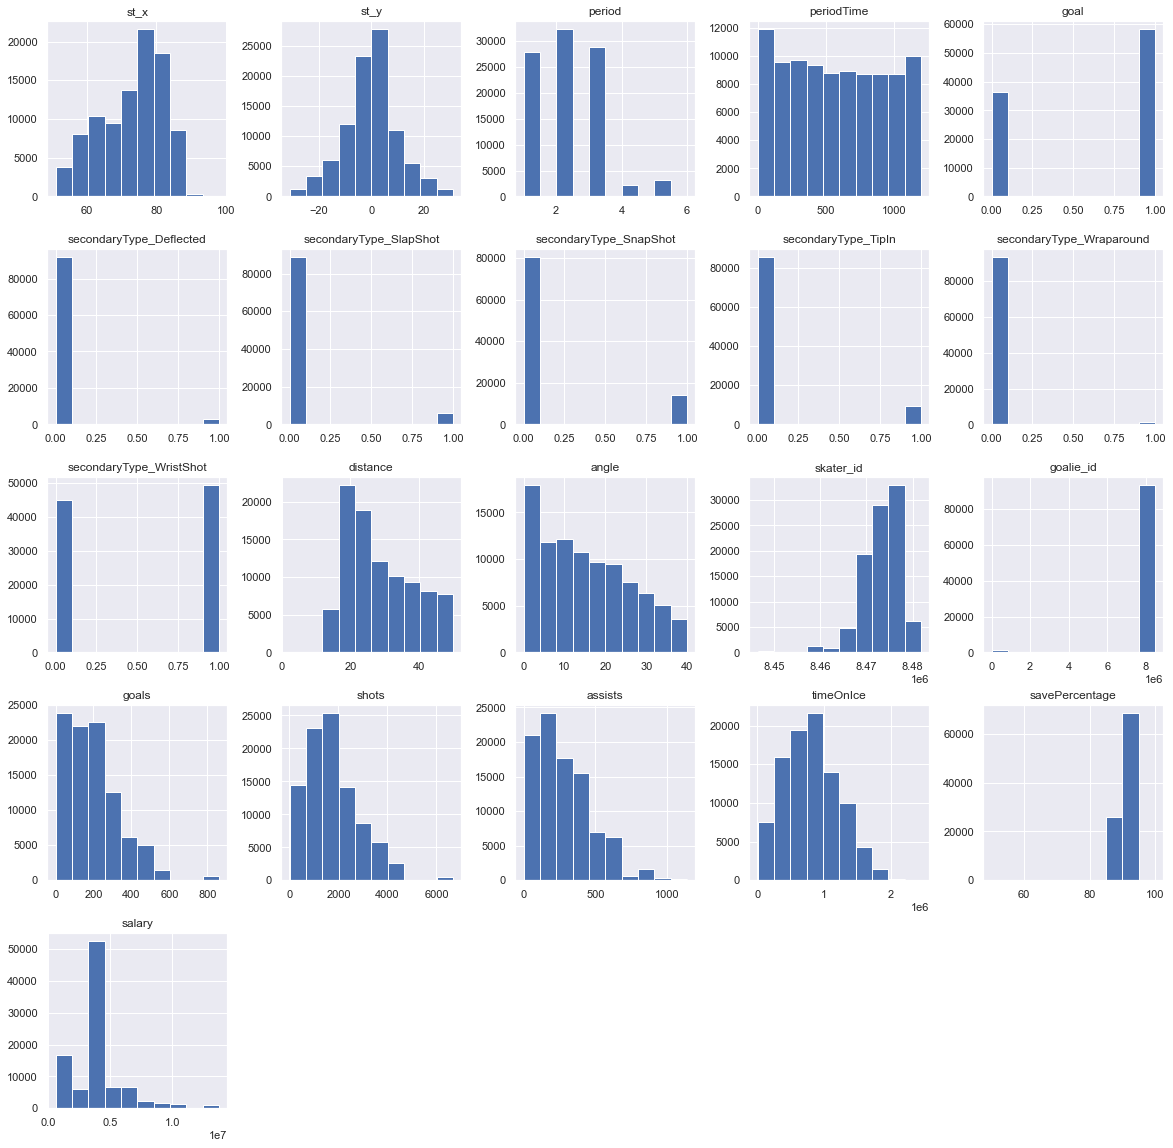

In [31]:
df_dataset.hist(figsize=(20, 20));

In [32]:
df_dataset = df_dataset[df_dataset.goals<400]
df_dataset = df_dataset[df_dataset.shots<4000]
df_dataset = df_dataset[df_dataset.assists<700]
df_dataset = df_dataset[df_dataset.salary<10000000]



## Re-train models with the new dataset including player's data

In [33]:
# starting training with player salary
_, lg = run_logistic_regression(df_dataset, conf_matrix=False, roc_curve=False);
_, lgbm = run_lightgbm_classifier(df_dataset, conf_matrix=False, roc_curve=False);
_, knc = run_kneighbors_classifier(df_dataset, conf_matrix=False, roc_curve=False);

save_metrics('8_with_player_salary', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc)

========== Logistic Regression ==========
Accuracy: 0.6093
F1 Score: 0.7572
AUC-ROC Score: 0.5208
-----------------------------------------
Precision: 0.6093
Recall: 1.0000
========== LightGBM Classifier ==========
Accuracy: 0.6562
F1 Score: 0.7524
AUC-ROC Score: 0.6683
-----------------------------------------
Precision: 0.6703
Recall: 0.8574
========= KNeighbors Classifier =========
Accuracy: 0.6065
F1 Score: 0.7496
AUC-ROC Score: 0.5385
-----------------------------------------
Precision: 0.6121
Recall: 0.9666


There was not really and improvement in the model. The values are more or less same.

---


### Look at the feature importance

========== LightGBM Classifier ==========
Accuracy: 0.6562
F1 Score: 0.7524
AUC-ROC Score: 0.6683
-----------------------------------------
Precision: 0.6703
Recall: 0.8574


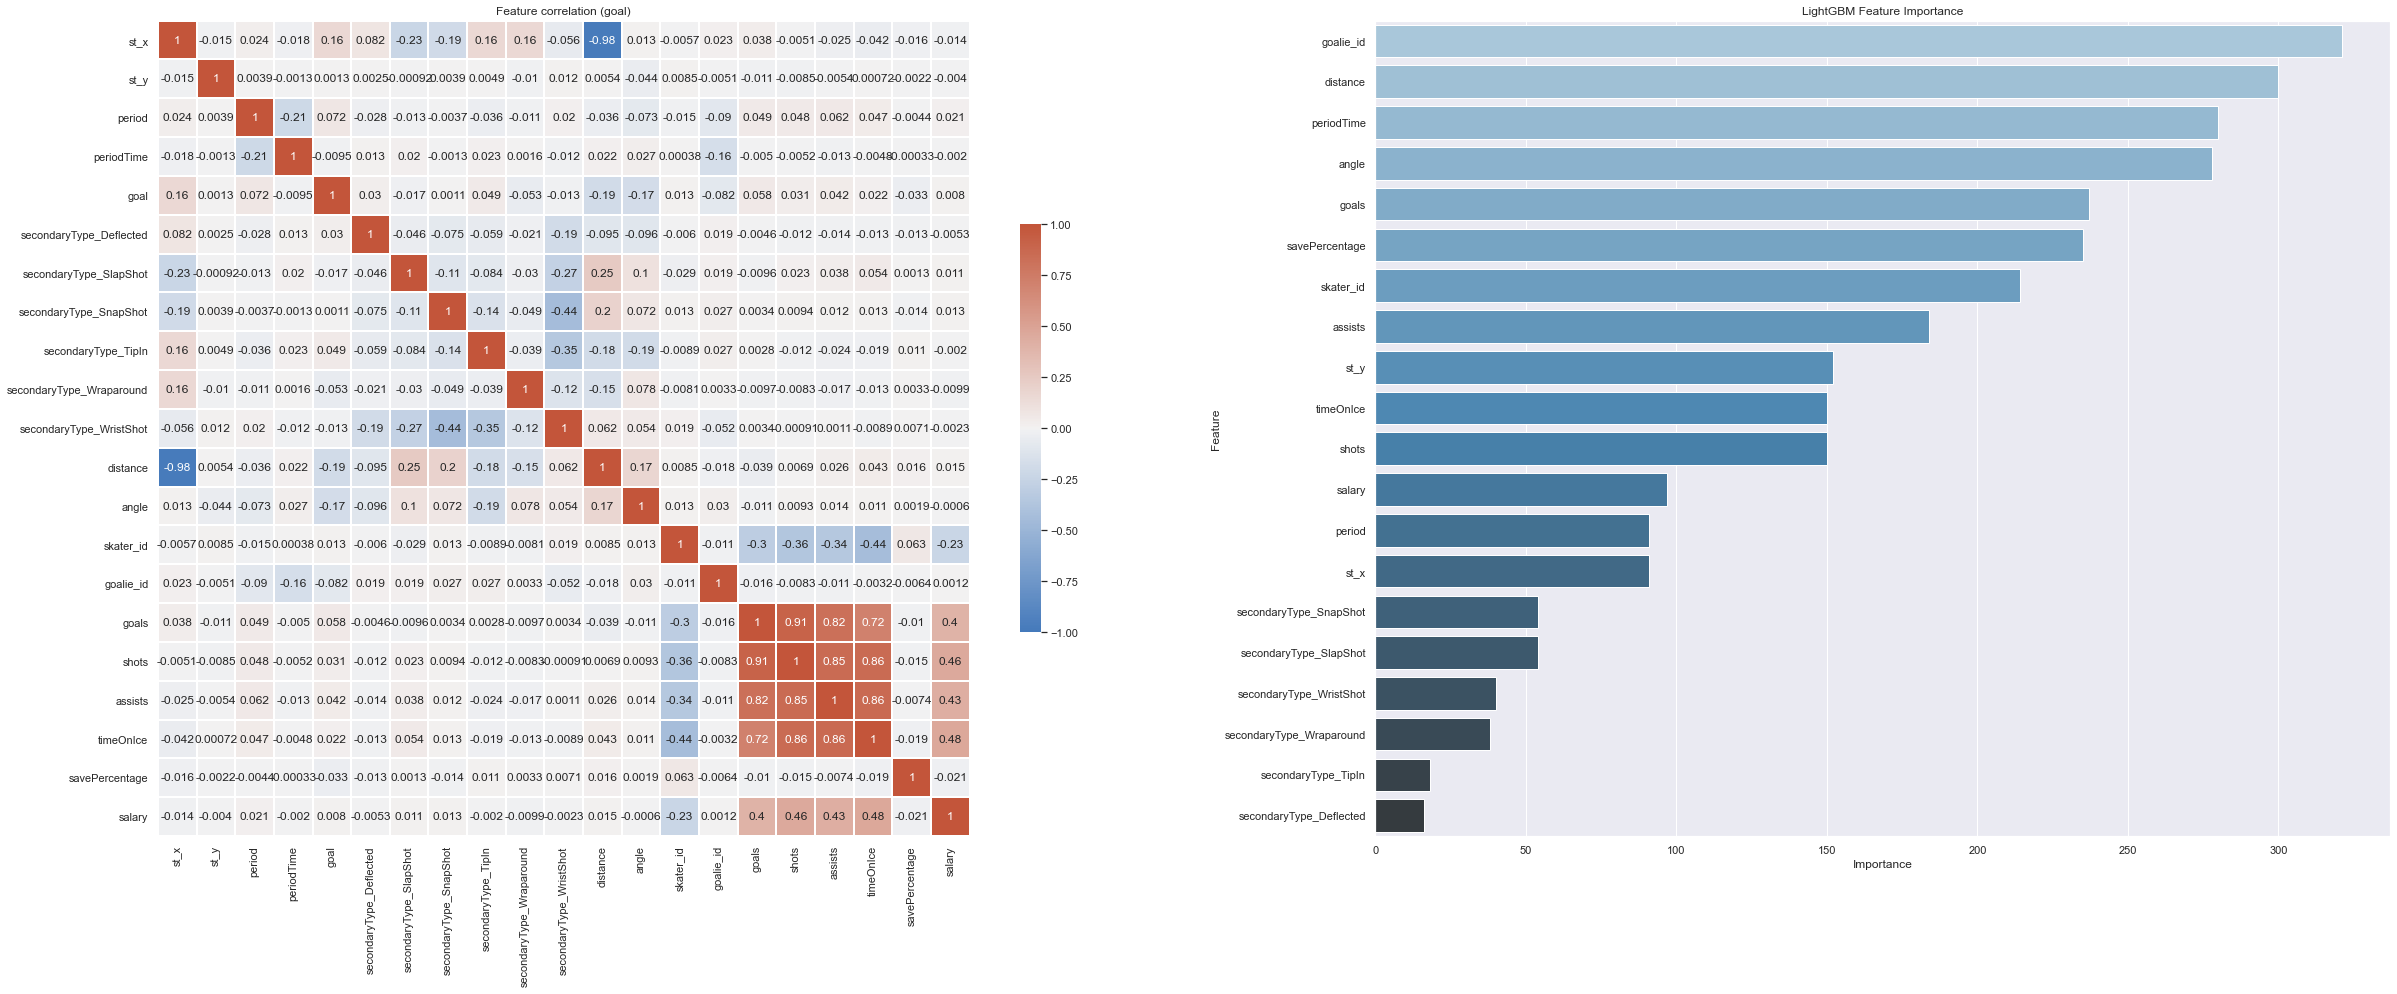

In [34]:
features = df_dataset.select_dtypes(exclude='object').columns.to_list()
features.remove('goal')

target = 'goal'

lgbm_model, _ = run_lightgbm_classifier(df_dataset, features=features, target=target, conf_matrix=False, roc_curve=False);


col='goal'
corr = df_dataset.corr()
cmap = sns.diverging_palette(250, 20, as_cmap=True)

plt.subplots(1, 2, figsize=(40, 15))
plt.subplot(121)

plt.title('Feature correlation (goal)')
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, linewidths=1, cbar_kws={"shrink": .5});

plt.subplot(122)
feature_imp = pd.DataFrame({'Importance':lgbm_model.feature_importances_,'Feature':features})
sns.barplot(x="Importance", y="Feature", palette='Blues_d', data=feature_imp.sort_values(by="Importance", ascending=False))
plt.title('LightGBM Feature Importance')
plt.show()

The most important features are goalie, dostance and agle. This definitely makes sense.

---

## Short vs. long distance shots

After all the feature engineering, let's see how is this model predisting on short vs. long distance shots. We split the dataset to two:

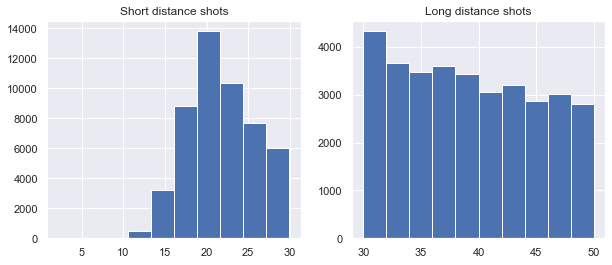

In [35]:
df_short_dist = df_dataset[df_dataset.distance<30]
df_long_dist = df_dataset[df_dataset.distance>=30]

plt.subplots(1, 2, figsize=(10, 4))
plt.subplot(121)
df_short_dist.distance.hist();
plt.title('Short distance shots');
plt.subplot(122)
df_long_dist.distance.hist();
plt.title('Long distance shots');

---
Plotting locations of the short distance shots:

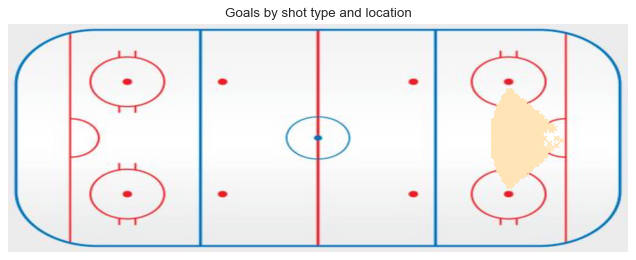

In [36]:
plt.figure(figsize=(10, 6), dpi=80)
img=plt.imread('data/images/rink.jpg')
plt.grid()
plt.axis("off")
plt.imshow(img, extent=[-125, 125, -46, 46])
plt.scatter(df_short_dist.st_x, df_short_dist.st_y, s=20, c='moccasin', marker='x');
plt.title('Goals by shot type and location');

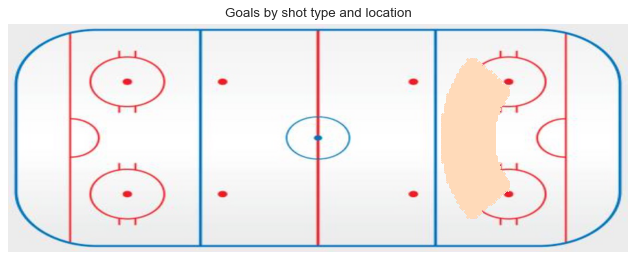

In [37]:
plt.figure(figsize=(10, 6), dpi=80)
img=plt.imread('data/images/rink.jpg')
plt.grid()
plt.axis("off")
plt.imshow(img, extent=[-125, 125, -46, 46])
plt.scatter(df_long_dist.st_x, df_long_dist.st_y, s=20, c='peachpuff', marker='x');
plt.title('Goals by shot type and location');

---
Predicting goals for both this groups:

In [38]:
# training with short distance shots
_, lg = run_logistic_regression(df_short_dist, conf_matrix=False, roc_curve=False);
_, lgbm = run_lightgbm_classifier(df_short_dist, conf_matrix=False, roc_curve=False);
_, knc = run_kneighbors_classifier(df_short_dist, conf_matrix=False, roc_curve=False);

save_metrics('9_short_dist', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc)

========== Logistic Regression ==========
Accuracy: 0.6792
F1 Score: 0.8089
AUC-ROC Score: 0.5238
-----------------------------------------
Precision: 0.6792
Recall: 1.0000
========== LightGBM Classifier ==========
Accuracy: 0.6890
F1 Score: 0.8055
AUC-ROC Score: 0.6292
-----------------------------------------
Precision: 0.7001
Recall: 0.9484
========= KNeighbors Classifier =========
Accuracy: 0.6777
F1 Score: 0.8075
AUC-ROC Score: 0.5349
-----------------------------------------
Precision: 0.6794
Recall: 0.9952


In [39]:
_, lg = run_logistic_regression(df_long_dist, conf_matrix=False, roc_curve=False);
_, lgbm = run_lightgbm_classifier(df_long_dist, conf_matrix=False, roc_curve=False);
_, knc = run_kneighbors_classifier(df_long_dist, conf_matrix=False, roc_curve=False);

save_metrics('10_long_dist', metrics_lg=lg, metrics_lgbm=lgbm, metrics_knc=knc)

========== Logistic Regression ==========
Accuracy: 0.5209
F1 Score: 0.6319
AUC-ROC Score: 0.5265
-----------------------------------------
Precision: 0.5238
Recall: 0.7961
========== LightGBM Classifier ==========
Accuracy: 0.6079
F1 Score: 0.6357
AUC-ROC Score: 0.6551
-----------------------------------------
Precision: 0.6111
Recall: 0.6624
========= KNeighbors Classifier =========
Accuracy: 0.5215
F1 Score: 0.5602
AUC-ROC Score: 0.5328
-----------------------------------------
Precision: 0.5333
Recall: 0.5901


---
### Conclusion on the short vs. long distance shots prediction: 
There is a huge difference between F1 score for predicting the goal probability for short distance vs. long distance shots. It looks like short distance goals are easier to predict. Those are apparently more dependent on featues recognized as important. On the other hand, the long distance goal do always include a **bit of luck**.


---
---